In [69]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import joblib
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [107]:
df = pd.read_csv('Financial_inclusion_dataset.csv')
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [12]:
df['marital_status'].unique()

array(['Married/Living together', 'Widowed', 'Single/Never Married',
       'Divorced/Seperated', 'Dont know'], dtype=object)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  int64 
 4   location_type           23524 non-null  int64 
 5   cellphone_access        23524 non-null  int64 
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  int64 
 9   relationship_with_head  23524 non-null  int64 
 10  marital_status          23524 non-null  int64 
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(9), object(4)
memory usage: 2.3+ MB


In [5]:
df.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [21]:
num = []
cat = []

for i in df.columns:
    if df[i].dtype == 'int64':
        num.append(i)

for i in df.columns:
    if df[i].dtype == 'object':
        cat.append(i)
cat, num

(['country',
  'uniqueid',
  'bank_account',
  'location_type',
  'cellphone_access',
  'gender_of_respondent',
  'relationship_with_head',
  'marital_status',
  'education_level',
  'job_type'],
 ['year', 'household_size', 'age_of_respondent'])

In [32]:
cat_label = ['bank_account','location_type','cellphone_access','gender_of_respondent','relationship_with_head','marital_status']

In [108]:
cat

['country', 'education_level', 'job_type']

In [60]:
num

['year',
 'location_type',
 'cellphone_access',
 'household_size',
 'age_of_respondent',
 'gender_of_respondent',
 'relationship_with_head',
 'marital_status']

In [ ]:
le = LabelEncoder()

for i in cat_label:
    df[i] = le.fit_transform(df[i])
    print(le.classes_)

In [103]:
df['country'].unique()

array(['Kenya', 'Rwanda', 'Tanzania', 'Uganda'], dtype=object)

In [51]:
df.drop('uniqueid',axis=1,inplace=True)

In [67]:
df['bank_account'].value_counts(normalize=True)

bank_account
NO     0.859208
YES    0.140792
Name: proportion, dtype: float64

In [61]:
target = 'bank_account'
inputs = df.drop(target,axis=1)

X = inputs
y = df[target]

In [62]:
class_ = Counter(y)
class_

Counter({'NO': 20212, 'YES': 3312})

In [64]:
ros = RandomOverSampler(random_state=30)
X_resam,y_resam = ros.fit_resample(X,y)

In [65]:
class_over = Counter(y_resam)
class_over

Counter({'YES': 20212, 'NO': 20212})

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X_resam,y_resam,test_size=0.2,random_state=30)

In [71]:
pre = ColumnTransformer(
    [
        ('cat',OneHotEncoder(handle_unknown='ignore'),cat),
        ('num','passthrough',num)
    ]
)

In [72]:
model = Pipeline(
    [
        ('p',pre),
        ('rf',RandomForestClassifier(random_state=30))
    ]
)

In [73]:
model.fit(X_train,y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'education_level',
                                                   'job_type']),
                                                 ('num', 'passthrough',
                                                  ['year', 'location_type',
                                                   'cellphone_access',
                                                   'household_size',
                                                   'age_of_respondent',
                                                   'gender_of_respondent',
                                                   'relationship_with_head',
                                                   'marital_status'])])),
                ('rf', RandomForestClassifier(random_state=30))])

In [74]:
y_pred = model.predict(X_test)

In [75]:
model.score(X_train,y_train)

0.9751383778100745

In [76]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.9275200989486704

In [79]:
classification = classification_report(y_test,y_pred)
print(classification)

              precision    recall  f1-score   support

          NO       0.98      0.88      0.92      4062
         YES       0.89      0.98      0.93      4023

    accuracy                           0.93      8085
   macro avg       0.93      0.93      0.93      8085
weighted avg       0.93      0.93      0.93      8085



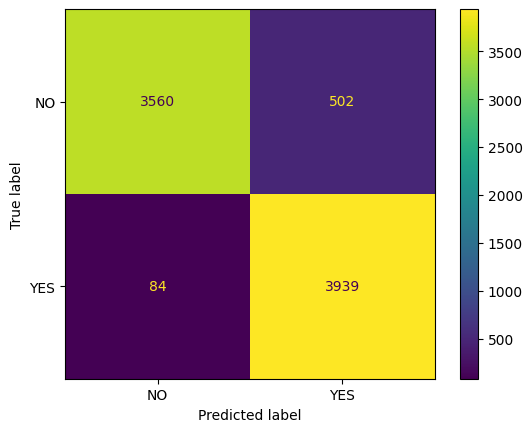

In [82]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [85]:
ohe = model.named_steps['p'].named_transformers_['cat']
feature_name = ohe.get_feature_names_out()
all_feature_name = num + list(feature_name)
all_feature_name

['year',
 'location_type',
 'cellphone_access',
 'household_size',
 'age_of_respondent',
 'gender_of_respondent',
 'relationship_with_head',
 'marital_status',
 'country_Kenya',
 'country_Rwanda',
 'country_Tanzania',
 'country_Uganda',
 'education_level_No formal education',
 'education_level_Other/Dont know/RTA',
 'education_level_Primary education',
 'education_level_Secondary education',
 'education_level_Tertiary education',
 'education_level_Vocational/Specialised training',
 'job_type_Dont Know/Refuse to answer',
 'job_type_Farming and Fishing',
 'job_type_Formally employed Government',
 'job_type_Formally employed Private',
 'job_type_Government Dependent',
 'job_type_Informally employed',
 'job_type_No Income',
 'job_type_Other Income',
 'job_type_Remittance Dependent',
 'job_type_Self employed']

In [87]:
importances = model.named_steps['rf'].feature_importances_

In [89]:
feat_imp = pd.DataFrame(
    {
        'feature' : all_feature_name,
        'importance' : importances
    }
).sort_values(by='importance',ascending=False)

<Axes: xlabel='importance', ylabel='feature'>

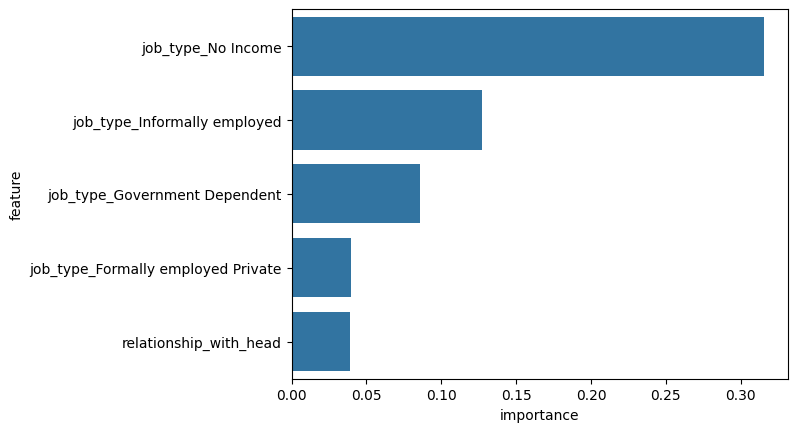

In [90]:
sns.barplot(feat_imp.head(),x='importance',y='feature')

In [91]:
with open('financial.pkl','wb') as f:
    joblib.dump(model,f)

In [114]:
df.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,YES,0,1,3,24,0,5,2,Secondary education,Self employed
1,Kenya,2018,NO,0,0,5,70,0,1,4,No formal education,Government Dependent
2,Kenya,2018,YES,1,1,5,26,1,3,3,Vocational/Specialised training,Self employed
3,Kenya,2018,NO,0,1,5,34,0,1,2,Primary education,Formally employed Private
4,Kenya,2018,NO,1,0,8,26,1,0,3,Primary education,Informally employed


In [109]:
encoders = {}

for col in cat_label:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    joblib.dump(le, f"le_{col}.pkl")

In [111]:
x={0:'NO',1:'YES'}
df['bank_account'] = df['bank_account'].map(x)

In [113]:
df.drop('uniqueid',axis=1,inplace=True)

In [ ]:
for col in cat_label:
    df[col] = le.fit_transform(df[col])
    print(le_classes_)

In [ ]:
encode = {}

for col in cat_label:
    df[col] = le.fit_transform(df[col])
    encode[col] = le
    with open (f'le_{col}.pkl','wb') as f:
        joblib.dump(le,f)

In [ ]:
for col in cols:
    le = joblib.load(f'le_{col}.pkl')
    input_df[col] = le.transform(df[col])
